# Bug Eyes

# Overview

SnapChat does not need an introduction but we’ll give a short one for those who have not heard of it. 

Evan Spiegel, Reggie Brown and Bobby Murphy from Stanford University founded SnapChat in September 2011. Their main idea was to create a selfie messaging application where the images were short-lived and automatically deleted within a few seconds of the person viewing them. It rebranded to Snap Inc. in September 2016 and after its IPO in 2017, the company made billions of dollars and its founders became Billionaires! 

Snapchat introduced features like Stories - where users can contribute snaps to a curated story available to all users, Memories - allowing users to save snaps and stories, Geostickers - has city-specific stickers that can be placed on snaps and messages and World Stickers - lets users add augmented reality objects into any scenery. 

**In this notebook we will cover Bug Eyes.** Several other filters will be covered next week. 

# Bug Eyes


As you might have guessed from the above figure, we are going to convert the eyes of a person to look large. 



 <center> <a href="https://www.learnopencv.com/wp-content/uploads/2019/10/bugEyeExample.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/bugEyeExample.jpg" width=700></a></center>




## Radial Distortion

We need to expand the image radially so that the eye region bulges outwards. This can be achieved using radial distorting the image. 

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2019/10/radial-distortions.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/radial-distortions.png"/></a></center>

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2019/10/radial-distortions-real-examples.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/radial-distortions-real-examples.png"/></a></center>


## Step 1 : Get the eye patch using DLib Facial Landmark detection

First, we use Dlib’s Facial Landmark detector to get the facial points. From the facial points, we extract the four points around each eye and obtain a square patch by adding some extra padding to the coordinates of the points. 

| <center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m7-cropedImage.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m7-cropedImage.jpg" width=250/></a></center> |  <center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m7-facialPoints.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m7-facialPoints.png" width=300/></a></center> |   <center> <a href="https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m7-originalEye.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2017/12/opcv4face-w4-m7-originalEye.png" width=320/></a></center> |
| -------- | -------- | -------- |
| <center>Original Grid</center>     | <center>Facial Points</center>     | <center>Extracted Eye Patch</center> |

## Step 2 : Apply radial Distortion to the eye patch

### 2.1 Normalize Coordinates

Let’s say the eye patch has a height h and width w. So, the coordinates range from 0 to w-1 and 0 to h-1. We first normalize the coordinates to -0.5 to +0.5 by dividing the x-coordinate values by w and subtracting 0.5 and y-coordinates by h and subtracting 0.5. Thus the point ( 0, 0 ) will become ( -0.5 , -0.5 ) and the point ( w , h ) will become ( 0.5, 0.5 ) after this normalization. 

In the equations below, all the coordinates will be referred to in this normalized space. 


### 2.2 Calculate Radial Distortion
There are many transformations that will create a bulging effect. The first thing to note is that the amount of distortion depends only on the distance from the center of the patch. So, we first calculate the radial distance of any point from the center. Let, a coordinates of a point in this normalized coordinates is $(x, y)$. The distance of this point from the center of the patch is given by 

$$
r = \sqrt{ x^2 + y^2 }
$$

To perform radial distortion, we can simply modify $r$ to say $r_d$ using a non-linear transformation $T$ and then rescale $x$ and $y$ based on the ratio of $r_d$ and $r$

$$
r_d = r + T(r) \\
x_d = \frac{x r_d}{r} \\
y_d = \frac{y r_d}{r} \\
$$

Now, we simply need to find a transformation $T$ that bulges the eyes. There are many such transformations, and we have chosen one of the following form

$$
r_d = r + k  \cdot r  \cdot cos(\pi r )
$$

Notice the following about the above equation
1. The distortion at the center is 0 because r is 0. 
2. The distortion in increases for a while as r increases. 
3. The distortion starts decreasing again as the cosine term starts decreasing and eventually goes to 0. 

Using the above equation when we transform a grid with k = 0 ( no distortion ) to k = 0.25, k = 0.5, and finally k = 0.75.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2019/10/bugeyes-warp-bad-boundary.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/bugeyes-warp-bad-boundary.png"/></a></center>

This looks good, but they values outside r = 0.5 are not handled properly. This leads to artifacts as you can see in the image below.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2019/10/bugEyeProblem.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/bugEyeProblem.jpg" width=500/></a></center>

Fortunately, this is rather easy to fix. We can simply set the distortion to 0, when r > 0.5. You can see the effect in the image below. 

<center><a href="https://www.learnopencv.com/wp-content/uploads/2019/10/bugeyes-warp.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/bugeyes-warp.png"/></a></center>


And, you can see the artifact is gone in the image 

<center><a href="https://www.learnopencv.com/wp-content/uploads/2019/10/bugEyeGood.jpg"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/bugEyeGood.jpg" width=500/></a></center>

## Step 3 : Interpolate the points using remap function in OpenCV

In OpenCV, we use the function **remap** for performing non-linear warps on an image. While using **remap** we need to specify the **[inverse mapping](http://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=reverse#)**! In other words, we do not specify how a pixel in the source image will be transformed. Instead, we start with the destination image, and find out where in the source image the pixel came from. 

<center> <a href="https://www.learnopencv.com/wp-content/uploads/2019/10/forward-backwarp-mapping.png"><img src = "https://www.learnopencv.com/wp-content/uploads/2019/10/forward-backwarp-mapping.png"/></a></center>

Now, you may find this a bit strange, but this is a standard way of performing warps. Imagine you have a 100x100 input image and for every pixel you perform the forward warp to obtain the output image. You will be suprised to see holes in the output image because a single pixel should occupy more than one pixel in many cases, and while doing the foward warp we are not taking that into consideration. 

On the other hand, if you start with the output image, and look up where a pixel came from in the input image, you will fill all pixels in the output image. If the calculated input pixel location is a floating point ( say, 32.5, 46.7), we can simply interpolate the color values from the neighbors ( i.e. (32, 46), (33,46), (32,47) and (33,47) ). 

A barrel distortion in the forward direction can also be thought as a pincushion distortion in the backward direction. Therefore, we will use a pincushion distortion while using **remap**. 

Fortunately, in our case, the change is simple. We simply subtract the distortion term instead of adding it to r. 

$$
r_d = r - k  \cdot r  \cdot cos(\pi r )
$$


## Bug Eyes Code and Tutorial

In this section, we will describe the video version of the Bug Eyes filter.  The image version shared in the code section is similar and easy to follow once you understand the video version. 

In [2]:
import cv2,dlib,time,argparse
import numpy as np
from dataPath import DATA_PATH
from dataPath import MODEL_PATH

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

We specify the default values for variables used in distortion.


In [8]:
modelPath = MODEL_PATH + "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(modelPath)
radius = 30

The code below implements the distortion function. 
First we create a undistorted meshgrid ( Xd, Yd ). 

Next, For every point on the mesh, we find the location of the point after deformation using the pincushion distortion. Note that We have to use pincushion distortion because OpenCV remap function applies the deformation in reverse order. 

The use of cosine function and minimum function should be noted.

Finally we use the remap function in OpenCV to get the output image with the distortion applied to it.

In [5]:
def barrel(src, k):
  w = src.shape[1]
  h = src.shape[0]

  # Meshgrid of destiation image
  x, y = np.meshgrid(np.arange(w), np.arange(h))
  
  # Normalize x and y
  x = np.float32(x)/w-0.5
  y = np.float32(y)/h-0.5

  # Radial distance from center
  r = np.sqrt(np.square(x) + np.square(y))

  # Implementing the following equaition
  # dr = k * r * cos(pi * r)
  dr =  np.multiply(k * r , np.cos(np.pi * r))
  
  # Outside the maximum radius dr is set to 0
  dr[r > 0.5] = 0 
    
  # Remember we need to provide inverse mapping to remap
  # Hence the negative sign before dr
  rn = r - dr    

  # Applying the distortion on the grid
  xd = cv2.divide( np.multiply( rn, x ), r)
  yd = cv2.divide( np.multiply( rn, y ), r)
    
  # Back to un-normalized coordinates  
  xd = w * ( xd + 0.5 )
  yd = h * ( yd + 0.5 )

  # Apply warp to source image using remap
  dst = cv2.remap(src, xd, yd, cv2.INTER_CUBIC)
  return dst

In [6]:
FACE_DOWNSAMPLE_RATIO = 1

def getLandmarks(im):
  imSmall = cv2.resize(im,None,
                       fx=1.0/FACE_DOWNSAMPLE_RATIO, 
                       fy=1.0/FACE_DOWNSAMPLE_RATIO, 
                       interpolation = cv2.INTER_LINEAR)
  #detect faces
  rects = detector(imSmall, 0)
  if len(rects) == 0:
    return 1
    
  #scale the points before sending to the pose predictor as 
  #we will send the original image 
  newRect = dlib.rectangle(int(rects[0].left()*FACE_DOWNSAMPLE_RATIO),
                           int(rects[0].top()*FACE_DOWNSAMPLE_RATIO),
                           int(rects[0].right()*FACE_DOWNSAMPLE_RATIO),
                           int(rects[0].bottom()*FACE_DOWNSAMPLE_RATIO))
  points = []
  [points.append((p.x, p.y)) for p in predictor(im, newRect).parts()]
  return points

Read image, apply Bug Eyes to each eye and display results

True

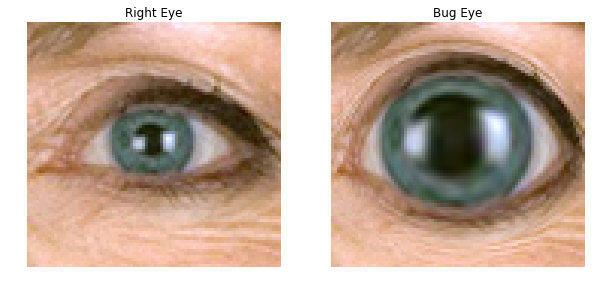

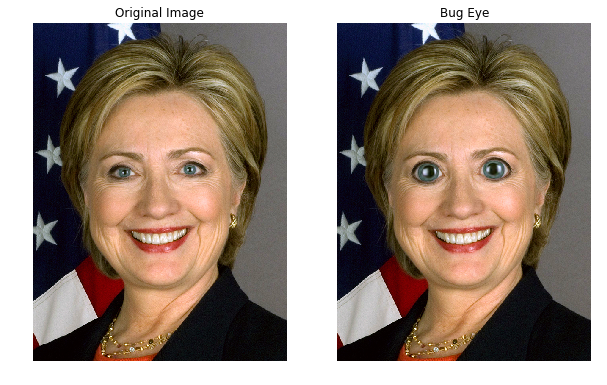

In [9]:
# Control the amount of deformation. 
bulgeAmount = 0.75

# Read image
input_file = DATA_PATH + "images/hillary-clinton.jpg"
src = cv2.imread(input_file)
height, width = src.shape[:2]

# Find the landmark points using DLIB Facial landmarks detector
landmarks = getLandmarks(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))

# Find the roi for left Eye
roiEyeLeft = [ landmarks[37][0] - radius, landmarks[37][1] - radius,
          (landmarks[40][0] - landmarks[37][0] + 2*radius),
          (landmarks[41][1] - landmarks[37][1] + 2*radius)  ]

# Find the roi for right Eye
roiEyeRight = [ landmarks[43][0] - radius, landmarks[43][1] - radius,
          (landmarks[46][0] - landmarks[43][0] + 2*radius),
          (landmarks[47][1] - landmarks[43][1] + 2*radius)  ]

output = np.copy(src)

# Find the patch for left eye and apply the transformation
leftEyeRegion = src[roiEyeLeft[1]:roiEyeLeft[1] + roiEyeLeft[3],roiEyeLeft[0]:roiEyeLeft[0] + roiEyeLeft[2]]
leftEyeRegionDistorted = barrel(leftEyeRegion, bulgeAmount);
output[roiEyeLeft[1]:roiEyeLeft[1] + roiEyeLeft[3],roiEyeLeft[0]:roiEyeLeft[0] + roiEyeLeft[2]] = leftEyeRegionDistorted

# Find the patch for right eye and apply the transformation
rightEyeRegion = src[roiEyeRight[1]:roiEyeRight[1] + roiEyeRight[3],roiEyeRight[0]:roiEyeRight[0] + roiEyeRight[2]]
rightEyeRegionDistorted = barrel(rightEyeRegion, bulgeAmount);
output[roiEyeRight[1]:roiEyeRight[1] + roiEyeRight[3],roiEyeRight[0]:roiEyeRight[0] + roiEyeRight[2]] = rightEyeRegionDistorted

plt.figure(figsize=[10,10])
plt.subplot(121);plt.imshow(rightEyeRegion[...,::-1]);plt.title("Right Eye")
plt.axis('off')
plt.subplot(122);plt.imshow(rightEyeRegionDistorted[...,::-1]);plt.title("Bug Eye")
plt.axis('off')

plt.figure(figsize=[10,10])
plt.subplot(121);plt.imshow(src[...,::-1]);plt.title("Original Image")
plt.axis('off')
plt.subplot(122);plt.imshow(output[...,::-1]);plt.title("Bug Eye")
plt.axis('off')

cv2.imwrite('output.jpg', output)


# References and Further reading

1. [https://en.wikipedia.org/wiki/Distortion_(optics)](https://en.wikipedia.org/wiki/Distortion_(optics))

2. [http://sprg.massey.ac.nz/pdfs/2003_IVCNZ_408.pdf](http://sprg.massey.ac.nz/pdfs/2003_IVCNZ_408.pdf)